# Import the necessary libraries and load the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob #deal with paths
import os #deal with paths
import cv2 #deal with images
from skimage.io import imread #read images from files
import matplotlib.pyplot as plt #make plots
import seaborn as sb #pretty plots :P 
%matplotlib inline 

# Load the data and explore a few images

This step was done using [Kevin's notebook](https://www.kaggle.com/kmader/histology-mnist-loading-and-processing-data) methods.

In [2]:
base_tile_dir = '../input/kather_texture_2016_image_tiles_5000/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir, '*', '*', '*.tif'))}) 
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
df['cell_type_idx'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
df['image_name'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
df['image_row'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
df['image_col'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
df['image'] = df['path'].map(imread)
df.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image
4956,../input/kather_texture_2016_image_tiles_5000/...,COMPLEX,03,769A_CRC-Prim-HE-03_002.tif,301,151,"[[[171, 89, 137], [157, 75, 123], [142, 65, 10..."
2845,../input/kather_texture_2016_image_tiles_5000/...,EMPTY,08,1235C_CRC-Prim-HE-06_005.tif,4351,751,"[[[242, 242, 242], [240, 240, 240], [240, 238,..."
3478,../input/kather_texture_2016_image_tiles_5000/...,TUMOR,01,3626_CRC-Prim-HE-02_031.tif,1,1,"[[[97, 69, 120], [77, 49, 100], [51, 28, 82], ..."
1359,../input/kather_texture_2016_image_tiles_5000/...,ADIPOSE,07,115A4_CRC-Prim-HE-07.tif,1201,3751,"[[[242, 240, 241], [245, 243, 244], [249, 245,..."
3587,../input/kather_texture_2016_image_tiles_5000/...,TUMOR,01,13721_CRC-Prim-HE-08_001.tif,1,451,"[[[92, 40, 78], [87, 35, 73], [88, 25, 67], [1..."


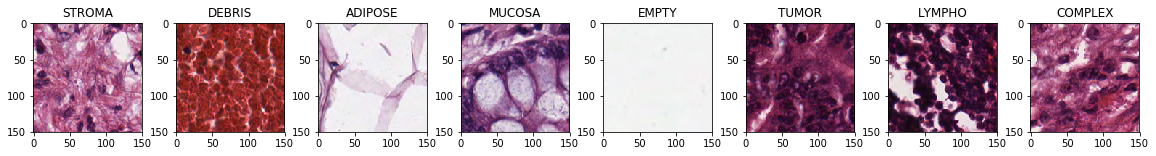

In [3]:
from random import randint

def get_first_cell_images(df):
    #get unique cell types
    unique_cell_type = df.cell_type.unique()
    cell_images = []
    for cell in unique_cell_type:
        #get the first row containing an image of cell_type == cell
        first_img_idx= np.where(df.cell_type == cell) 
        #list containing one image of each type
        cell_images.append((df[df.cell_type == cell].loc[first_img_idx[0][0],'image'], cell))
    return cell_images

images = get_first_cell_images(df)

#create the subplots
fig, m_axs = plt.subplots(1, len(images), figsize = (20, 2))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])


In [4]:
from keras.preprocessing import image                  
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True     
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(150,150))
    # convert PIL.Image.Image type to 3D tensor with shape (150, 150, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

images_path = list(df.path)

images_tensors = paths_to_tensor(images_path)

images_tensors.shape

Using TensorFlow backend.
100%|██████████| 5000/5000 [00:05<00:00, 859.28it/s]


(5000, 150, 150, 3)

In [5]:
df.cell_type.unique()

array(['STROMA', 'DEBRIS', 'ADIPOSE', 'MUCOSA', 'EMPTY', 'TUMOR',
       'LYMPHO', 'COMPLEX'], dtype=object)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils


train_fraction = 0.8

encoder = LabelBinarizer()
y = encoder.fit_transform(df.cell_type)
x = images_tensors

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

val_size = int(0.5*len(test_tensors))

val_tensors = test_tensors[:val_size]
val_targets = test_targets[:val_size]
test_tensors = test_tensors[val_size:]
test_targets = test_targets[val_size:]

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Now I'll run the CNN itself. The architecture will be 3 Conv2D -> Dropout -> Maxpooling 4 times, followed by a global maxpooling. At the end, I run the outputs through a fully connected layer to get the probabilities. 

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from tensorflow import set_random_seed

set_random_seed(42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)    

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 40
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=20, verbose=1, callbacks = [early_stopping, checkpointer])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 4000 samples, validate on 500 samples
Epoch 1/40
4000/4000 [==============================] - 10s 2ms/step - loss: 1.8781 - acc: 0.2585 - val_loss: 1.5311 - val_acc: 0.4700

Epoch 00001: val_loss improved from inf to 1.53105, saving model to weights.hdf5
Epoch 2/40
4000/4000 [==============================] - 4s 1ms/step - loss: 1.2641 - acc: 0.4920 - val_loss: 1.2980 - val_acc: 0.5820

Epoch 00002: val_loss improved from 1.53105 to 1.29802, saving model to weights.hdf5
Epoch 3/40
4000/4000 [==============================] - 4s 1ms/step - loss: 0.9783 - acc: 0.6207 - val_loss: 0.9160 - val_acc: 0.6740

Epoch 00003: val_loss improved from 1.29802 to 0.91603, saving model to weights.hdf5
Epoch 4/40
4000/4000 [==============================] - 4s 1ms/step - loss: 0.8435 - acc: 0.6757 - val_loss: 0.8221 - val_acc: 0.7500

Epoch 00004: val_loss improved from

In [9]:
model.load_weights('weights.hdf5')

cell_predictions =  [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(cell_predictions)==np.argmax(test_targets, axis=1))/len(cell_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.6000%
